In [52]:
pip install pandas numpy matplotlib seaborn nltk scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import os
import email
import pickle
import joblib
from urllib.parse import urlparse
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score
from sklearn.metrics import roc_curve, auc
import warnings
import time
warnings.filterwarnings('ignore')

# Thiết lập hiển thị và tải stopwords
pd.set_option('display.max_colwidth', 200)
plt.style.use('ggplot')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HUNG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    #1. Chuyển thành chữ thường
    text = text.lower()
    #2. Loại bỏ các ký tự đặc biệt và số
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    #3. Stemming
    stemmer = PorterStemmer()
    words = text.split()
    words = [stemmer.stem(word) for word in words]
    #4. Loại bỏ stopwords
    stop_words = set(stopwords.words('english'))
    words = [stemmer.stem(word) for word in words]
    
    return ' '.join(words)

In [5]:
def extract_urls(text):
    """Trích xuất các URL từ nội dung email.
    
    Args:
        text (str): Nội dung email.
    
    Returns:
        list: Danh sách các URL.
    """
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    urls = re.findall(url_pattern, text)
    return urls

def is_suspicious_url(url):
    """Kiểm tra xem URL có đáng ngờ hay không.
    
    Args:
        url (str): URL cần kiểm tra.
    
    Returns:
        int: 1 nếu đáng ngờ, 0 nếu không.
    """
    suspicious_domains = ['.xyz', '.top', '.info', '.club', '.online']
    parsed = urlparse(url)
    domain = parsed.netloc.lower()
    return 1 if any(domain.endswith(susp) for susp in suspicious_domains) or len(domain) > 50 else 0

def extract_email_features(msg):
    """Trích xuất các đặc trưng từ email.
    
    Args:
        msg (email.message): Đối tượng email.
    
    Returns:
        dict: Từ điển chứa nội dung, tiêu đề, người gửi, và thông tin URL.
    """
    features = {}
    content = ""
    
    if msg.is_multipart():
        for part in msg.walk():
            if part.get_content_type() == 'text/plain':
                content += part.get_payload(decode=True).decode('latin-1', errors='ignore')
    else:
        content = msg.get_payload(decode=True).decode('latin-1', errors='ignore')
    
    features['content'] = preprocess_text(content)
    features['subject'] = preprocess_text(msg.get('subject', ''))
    features['from'] = preprocess_text(msg.get('from', ''))
    features['has_suspicious_url'] = 0
    
    urls = extract_urls(content)
    if urls:
        features['has_suspicious_url'] = max(is_suspicious_url(url) for url in urls)
    
    return features

In [7]:
def load_emails_from_directory(directory):
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Thư mục {directory} không tồn tại!")
    
    feature_list = []
    labels = []
    
    for label in ['spam', 'ham']:
        label_path = os.path.join(directory, label)
        if not os.path.exists(label_path):
            continue
            
        print(f"Đang xử lý {label}...")
        for filename in os.listdir(label_path):
            file_path = os.path.join(label_path, filename)
            
            try:
                with open(file_path, 'r', encoding='latin-1') as f:
                    msg = email.message_from_file(f)
                    features = extract_email_features(msg)
                    
                    if features['content']:  # Chỉ thêm nếu có nội dung
                        feature_list.append(features)
                        labels.append(1 if label == 'spam' else 0)
            except Exception as e:
                print(f"Lỗi khi xử lý {filename}: {str(e)}")
    
    return feature_list, labels

# Tải và xử lý dữ liệu
dataset_path = "email"
print("⏳ Đang tải dữ liệu...")
feature_list, labels = load_emails_from_directory(dataset_path)
print(f"✅ Đã tải xong {len(feature_list)} emails (Spam: {sum(labels)}, Ham: {len(labels)-sum(labels)})")

# Lưu dữ liệu gốc
with open('original_features.pkl', 'wb') as f:
    pickle.dump(feature_list, f)
with open('original_labels.pkl', 'wb') as f:
    pickle.dump(labels, f)

⏳ Đang tải dữ liệu...
Đang xử lý spam...
Đang xử lý ham...
Lỗi khi xử lý .ipynb_checkpoints: [Errno 13] Permission denied: 'email\\ham\\.ipynb_checkpoints'
✅ Đã tải xong 23516 emails (Spam: 11192, Ham: 12324)


In [10]:
from scipy.sparse import hstack

# Chuyển đổi sang TF-IDF và kết hợp đặc trưng
print("\n🛠️ Đang chuyển đổi dữ liệu...")
tfidf_vectorizer_content = TfidfVectorizer(max_features=3000, stop_words='english', ngram_range=(1, 2))
tfidf_vectorizer_subject = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_vectorizer_from = TfidfVectorizer(max_features=300, stop_words='english')

contents = [f['content'] for f in feature_list]
subjects = [f['subject'] for f in feature_list]
froms = [f['from'] for f in feature_list]
urls = np.array([f['has_suspicious_url'] for f in feature_list]).reshape(-1, 1)

X_content = tfidf_vectorizer_content.fit_transform(contents)
X_subject = tfidf_vectorizer_subject.fit_transform(subjects)
X_from = tfidf_vectorizer_from.fit_transform(froms)
X = hstack([X_content, X_subject, X_from, urls.astype(np.float32)])
y = np.array(labels)


# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)


🛠️ Đang chuyển đổi dữ liệu...


In [12]:
# Khởi tạo mô hình Random Forest
print("\n🛠️ Khởi tạo mô hình Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=30,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Huấn luyện mô hình
print("🚀 Đang huấn luyện mô hình Random Forest...")
start_time = time.time()
rf_model.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"✅ Hoàn tất huấn luyện! Thời gian huấn luyện: {training_time:.2f} giây")


🛠️ Khởi tạo mô hình Random Forest...
🚀 Đang huấn luyện mô hình Random Forest...
✅ Hoàn tất huấn luyện! Thời gian huấn luyện: 1.34 giây



📊 Đang đánh giá mô hình trên tập test...

🔍 Độ chính xác: 95.66%
🔍 Độ nhạy (Spam): 98.79%
🔍 Độ nhạy (Ham): 92.82%
🔍 Độ đặc hiệu (Spam): 92.82%

📝 Báo cáo phân loại:
              precision    recall  f1-score   support

         Ham       0.99      0.93      0.96      2465
        Spam       0.93      0.99      0.96      2239

    accuracy                           0.96      4704
   macro avg       0.96      0.96      0.96      4704
weighted avg       0.96      0.96      0.96      4704



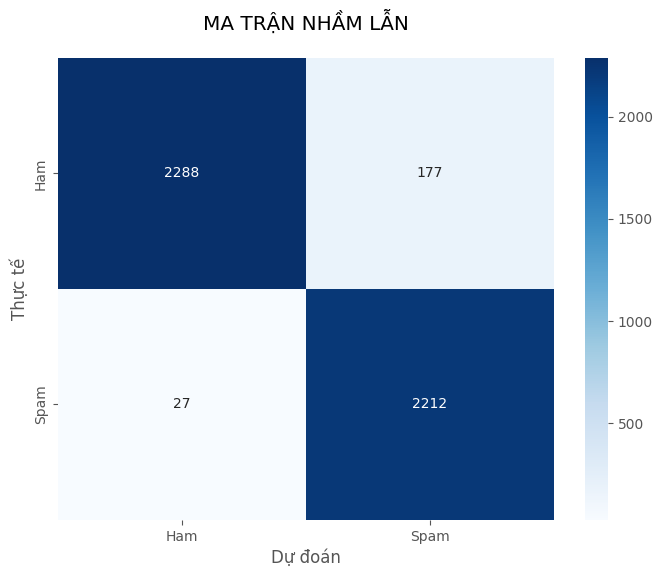

In [13]:
# Đánh giá mô hình trên tập test
print("\n📊 Đang đánh giá mô hình trên tập test...")
y_pred = rf_model.predict(X_test)

# Tính các chỉ số đánh giá
accuracy = accuracy_score(y_test, y_pred)
recall_spam = recall_score(y_test, y_pred, pos_label=1)
recall_ham = recall_score(y_test, y_pred, pos_label=0)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)

print(f"\n🔍 Độ chính xác: {accuracy*100:.2f}%")
print(f"🔍 Độ nhạy (Spam): {recall_spam*100:.2f}%")
print(f"🔍 Độ nhạy (Ham): {recall_ham*100:.2f}%")
print(f"🔍 Độ đặc hiệu (Spam): {specificity*100:.2f}%")

# Báo cáo chi tiết
print("\n📝 Báo cáo phân loại:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8,6))
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.title('MA TRẬN NHẦM LẪN', pad=20)
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

In [79]:
import numpy as np
import pandas as pd

# Phân tích lỗi
print("\n🔎 Phân tích lỗi phân loại...")
false_positives = []
false_negatives = []
feature_names = (
    tfidf_vectorizer_content.get_feature_names_out().tolist() +
    tfidf_vectorizer_subject.get_feature_names_out().tolist() +
    tfidf_vectorizer_from.get_feature_names_out().tolist() +
    ['has_suspicious_url']
)

for i in range(len(y_test)):
    if y_test[i] == 0 and y_pred[i] == 1:  # False Positive
        email_idx = X_test[i].nonzero()[1]  # Lấy chỉ số cột của các giá trị khác 0
        important_words = [feature_names[idx] for idx in email_idx]
        false_positives.append((feature_list[i + len(y_train)]['content'], important_words))
    elif y_test[i] == 1 and y_pred[i] == 0:  # False Negative
        email_idx = X_test[i].nonzero()[1]  # Lấy chỉ số cột của các giá trị khác 0
        important_words = [feature_names[idx] for idx in email_idx]
        false_negatives.append((feature_list[i + len(y_train)]['content'], important_words))

print(f"\n📌 10 False Positives (Ham bị dự đoán là Spam):")
for i, (content, words) in enumerate(false_positives[:10], 1):
    print(f"{i}. Nội dung: {content[:100]}...")
    print(f"   Từ khóa: {', '.join(words[:5])}")

print(f"\n📌 10 False Negatives (Spam bị dự đoán là Ham):")
for i, (content, words) in enumerate(false_negatives[:10], 1):
    print(f"{i}. Nội dung: {content[:100]}...")
    print(f"   Từ khóa: {', '.join(words[:5])}")

# Phân tích từ khóa quan trọng
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n📊 Top 10 đặc trưng quan trọng nhất để phát hiện spam:")
print(importance_df.head(10))
print("\n📊 Top 10 đặc trưng ít quan trọng nhất:")
print(importance_df.tail(10))


🔎 Phân tích lỗi phân loại...

📌 10 False Positives (Ham bị dự đoán là Spam):
1. Nội dung: bill when do you want to meet with todd to discuss hi perform also will we be make him an offer than...
   Từ khóa: camp, com, confus, copi, date
2. Nội dung: the it complianc team ha been ask to conduct a process review and process develop project with the c...
   Từ khóa: agreement, deliveri, effect, mmbtu, transact
3. Nội dung: use perl daili newslett in thi issu perl port page perl port page post by hfb on saturday august cpa...
   Từ khóa: age, ann, art, attempt, author
4. Nội dung: forwardedbi nev dull nevsleepycatcom forwardedbi newslettertvspycom excerpt shoptalk septemb im a ta...
   Từ khóa: list, mail, mail list, seri, short
5. Nội dung: cantekin can you figur out the reason for cocoa bean var fluctuat the same is true of aluminum i ass...
   Từ khóa: director, educ, happi, holiday, hope
6. Nội dung: thi wa elsi s respons to my question about dpr rate actual charg on the real time pma 

In [16]:
# Hàm cập nhật mô hình
def update_model(new_emails, new_labels):
    """Cập nhật mô hình với email mới.
    
    Args:
        new_emails (list): Danh sách đối tượng email mới.
        new_labels (list): Danh sách nhãn tương ứng (0: ham, 1: spam).
    """
    if len(new_emails) != len(new_labels):
        raise ValueError("Số lượng email và nhãn không khớp!")
    if not all(label in [0, 1] for label in new_labels):
        raise ValueError("Nhãn phải là 0 (ham) hoặc 1 (spam)!")
    
    with open('original_features.pkl', 'rb') as f:
        old_features = pickle.load(f)
    with open('original_labels.pkl', 'rb') as f:
        old_labels = pickle.load(f)
    
    new_features = [extract_email_features(email.message_from_string(email)) for email in new_emails]
    updated_features = old_features + new_features
    updated_labels = old_labels + new_labels
    
    contents = [f['content'] for f in updated_features]
    subjects = [f['subject'] for f in updated_features]
    froms = [f['from'] for f in updated_features]
    urls = np.array([f['has_suspicious_url'] for f in updated_features]).reshape(-1, 1)
    
    X_content = tfidf_vectorizer_content.fit_transform(contents)
    X_subject = tfidf_vectorizer_subject.fit_transform(subjects)
    X_from = tfidf_vectorizer_from.fit_transform(froms)
    X_updated = np.hstack((X_content.toarray(), X_subject.toarray(), X_from.toarray(), urls))
    y_updated = np.array(updated_labels)
    
    rf_model.fit(X_updated, y_updated)
    
    with open('original_features.pkl', 'wb') as f:
        pickle.dump(updated_features, f)
    with open('original_labels.pkl', 'wb') as f:
        pickle.dump(updated_labels, f)
    joblib.dump(rf_model, 'phishing_detector_rf_final.pkl')
    joblib.dump((tfidf_vectorizer_content, tfidf_vectorizer_subject, tfidf_vectorizer_from), 'tfidf_vectorizers.pkl')
    print("✅ Đã cập nhật mô hình với dữ liệu mới!")

In [21]:
# Hàm nhận diện
def detect_phishing(email_text):
    """Nhận diện email spam/phishing.
    
    Args:
        email_text (str): Nội dung email dạng văn bản.
    """
    msg = email.message_from_string(email_text)
    features = extract_email_features(msg)
    
    content_vec = tfidf_vectorizer_content.transform([features['content']])
    subject_vec = tfidf_vectorizer_subject.transform([features['subject']])
    from_vec = tfidf_vectorizer_from.transform([features['from']])
    url_vec = np.array([features['has_suspicious_url']]).reshape(-1, 1)
    
    text_vector = np.hstack((content_vec.toarray(), subject_vec.toarray(), from_vec.toarray(), url_vec))
    prediction = rf_model.predict(text_vector)[0]
    proba = rf_model.predict_proba(text_vector)[0][1]
    
    result = "SPAM (lừa đảo)" if prediction == 1 else "HAM (hợp lệ)"
    print(f"\n🔮 Kết quả: {result}")
    print(f"📈 Độ tin cậy: {proba*100:.2f}%")
    print("\n📌 Các đặc trưng quan trọng ảnh hưởng đến quyết định:")
    
    feature_names = (
        tfidf_vectorizer_content.get_feature_names_out().tolist() +
        tfidf_vectorizer_subject.get_feature_names_out().tolist() +
        tfidf_vectorizer_from.get_feature_names_out().tolist() +
        ['has_suspicious_url']
    )
    coef = rf_model.feature_importances_
    top_indices = np.argsort(coef)[::-1][:10]
    for i in top_indices:
        if text_vector[:, i].sum() > 0:
            print(f"- {feature_names[i]} (importance: {coef[i]:.4f})")

# Test demo
test_email = """
Subject: Please Update Your Employee Profile

From: hr@company.com

Hello [Employee],

We’re updating our employee database. Please update your profile by clicking here: http://hr.company.com/update-profile.
This is required to ensure your information is current.

Best regards,

HR Team
"""
detect_phishing(test_email)


🔮 Kết quả: SPAM (lừa đảo)
📈 Độ tin cậy: 59.68%

📌 Các đặc trưng quan trọng ảnh hưởng đến quyết định:
- click (importance: 0.0118)


In [47]:
print(f"\n📈 Số lượng email huấn luyện: {len(y_train)} (Spam: {sum(y_train)}, Ham: {len(y_train) - sum(y_train)})")
print(f"📈 Số lượng email kiểm tra: {len(y_test)} (Spam: {sum(y_test)}, Ham: {len(y_test) - sum(y_test)})")


📈 Số lượng email huấn luyện: 18812 (Spam: 8953, Ham: 9859)
📈 Số lượng email kiểm tra: 4704 (Spam: 2239, Ham: 2465)
